In [1]:
import numpy as np
import pandas as pd
import math
from plotnine import *
from sklearn.linear_model import LogisticRegression

In [2]:
N_TREATMENT= 1000
N_CONTROL = 1000
BINWIDTH = 5

In [3]:
def discretize_values(df, binwidth=BINWIDTH):  
    df["discrete_values"] = np.floor(df["values"]/binwidth)*binwidth + binwidth/2
    df = df.groupby(["Group", "discrete_values"]).agg(
        freq=pd.NamedAgg(column='values', aggfunc='count')).reset_index()
    df["frac_freq"] = df["freq"]/df["freq"].sum()
    return df

def match_treatment_units(dat):
    control_dat = dat.query("Group=='control'").reset_index()
    dat["matched_values"] = dat["values"].transform(lambda x: control_dat["values"][np.argmin(np.abs(control_dat["values"]-x))] )
    treatment_dat = dat.query("Group=='treatment'").copy()
    treatment_dat["unit_id"] = np.arange(treatment_dat.shape[0])
    return treatment_dat

def add_inverse_propensity_weights(dat, estimate_type="att"):
    dat["treatment"]= np.where(dat["Group"]=="treatment", 1, 0)
    X = dat["values"].to_numpy()[:, np.newaxis]
    y = dat["treatment"]
    clf = LogisticRegression().fit(X,y )
    print("Accuracy: "+str(clf.score(X,y)))
    prob_treatment= clf.predict_proba(X)
    if estimate_type=="att":
        dat["weight"] = np.where(dat["Group"]=="treatment", 
                                 1, #1/prob_treatment[:,1], 
                                 prob_treatment[:,1]/prob_treatment[:,0])#1/prob_treatment[:,0])
    return dat

## Datasets

### Dataset 0 with perfect overlap

In [4]:
# todo: can make this age, e.g. 0 to 100.
treatment_w = np.random.normal(52, 15, N_TREATMENT)
control_w = np.random.beta(9, 5, N_CONTROL)*100
dat_t = pd.DataFrame({'Group':"treatment",'values':treatment_w})
dat_c = pd.DataFrame({'Group':"control",'values':control_w})
dat0 = dat_c.append(dat_t)
dat0 = dat0.query("values>=30 & values<80")

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: continuous_perfect_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


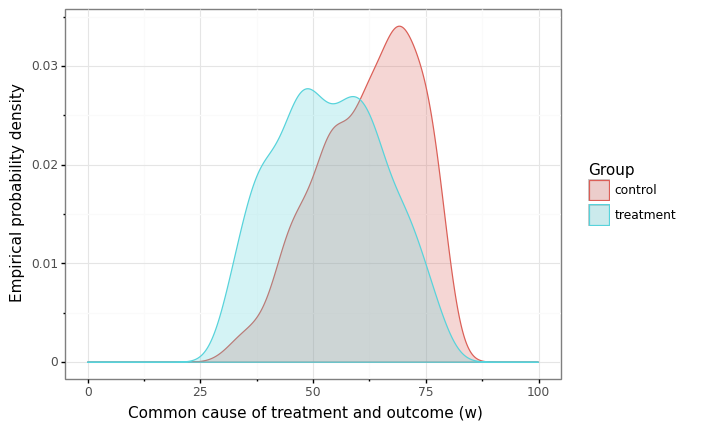

<ggplot: (8756175380067)>


In [5]:
plt_cont_0 = (
 ggplot(dat0, aes(x="values", color="Group", fill="Group")) +
 geom_density(alpha=0.25, position="identity")+
 xlab("Common cause of treatment and outcome (w)")+
 ylab("Empirical probability density")+
 theme_bw()+
 xlim(0,100)
)
ggsave(plt_cont_0, filename="continuous_perfect_overlap.pdf", width=3, height=3)
print(plt_cont_0)

### Dataset 1 with partial overlap

In [6]:
treatment_w = np.random.normal(40, 7, N_TREATMENT)
control_w = np.random.beta(9, 5, N_CONTROL)*100
dat_t = pd.DataFrame({'Group':"treatment",'values':treatment_w})
dat_c = pd.DataFrame({'Group':"control",'values':control_w})
dat1 = dat_c.append(dat_t)
dat1 = dat1.query("values>=30 & values<80").reset_index()

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: continuous_treatment_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


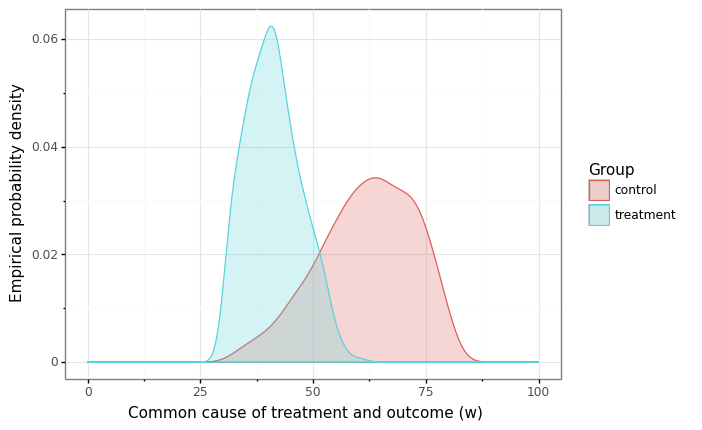

<ggplot: (8756172617725)>


In [7]:
plt_cont_1 = (
 ggplot(dat1, aes(x="values", color="Group", fill="Group")) +
 geom_density(alpha=0.25, position="identity")+
 xlab("Common cause of treatment and outcome (w)")+
 ylab("Empirical probability density")+
 theme_bw()+
 xlim(0,100)
)
ggsave(plt_cont_1, filename="continuous_treatment_overlap.pdf", width=3, height=3)
print(plt_cont_1)

In [8]:
### Dataset 2 with worse overlap

In [9]:
treatment_w = np.random.normal(30, 10, N_TREATMENT)
control_w = np.random.beta(9, 5, N_CONTROL)*100
dat_t = pd.DataFrame({'Group':"treatment",'values':treatment_w})
dat_c = pd.DataFrame({'Group':"control",'values':control_w})
dat2 = dat_c.append(dat_t)
dat2 = dat2.query("values>=10 & values<80").reset_index()

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: continuous_partial_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


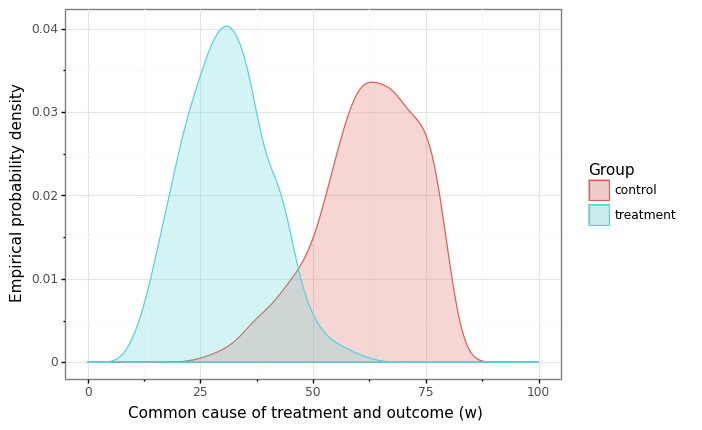

<ggplot: (8756172547504)>

In [10]:
plt_cont_2 = (ggplot(dat2, aes(x="values", color="Group", fill="Group")) +
geom_density(alpha=0.25, position="identity")+
 xlab("Common cause of treatment and outcome (w)")+
 ylab("Empirical probability density") +
 xlim(0,100)+
 theme_bw()
)
ggsave(plt_cont_2, filename="continuous_partial_overlap.pdf", width=3, height=3)
plt_cont_2

## Stratification

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: stratification_perfect_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


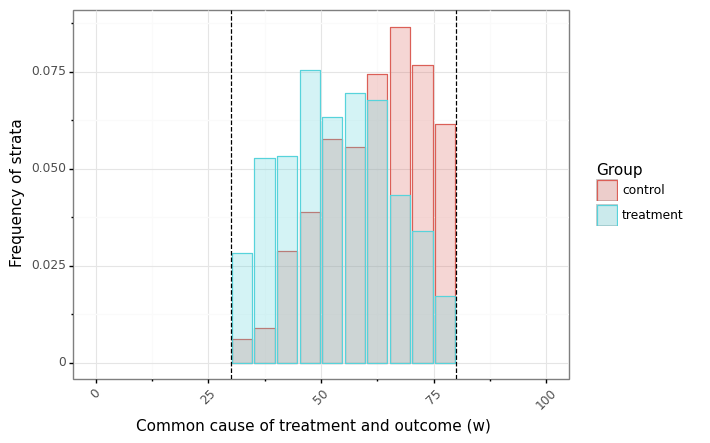

<ggplot: (-9223363280682154780)>

In [11]:
binned_dat0 = discretize_values(dat0)
plt_strat_0 = (
 ggplot(binned_dat0, aes(x="discrete_values", y="frac_freq", color="Group", fill="Group")) +
 geom_bar(alpha=0.25, position="identity", stat="identity")+
 xlab("Common cause of treatment and outcome (w)")+
 ylab("Frequency of strata")+
 xlim(0,100) +
 geom_vline(xintercept=30, linetype="dashed") + geom_vline(xintercept=80, linetype="dashed")+
 theme_bw()+
 theme(axis_text_x = element_text(angle=45))
)
ggsave(plt_strat_0, filename="stratification_perfect_overlap.pdf", width=3, height=3)
plt_strat_0

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: stratification_treatment_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


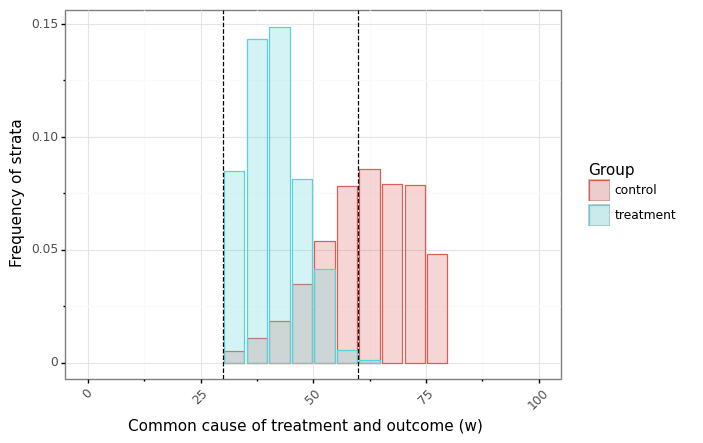

<ggplot: (8756172488347)>

In [12]:
binned_dat1 = discretize_values(dat1)
plt_strat_1 = (ggplot(binned_dat1, aes(x="discrete_values", y="frac_freq", color="Group", fill="Group")) +
geom_bar(alpha=0.25, position="identity", stat="identity")+
 xlab("Common cause of treatment and outcome (w)")+
 ylab("Frequency of strata")+
 xlim(0,100) +
 geom_vline(xintercept=30, linetype="dashed") + geom_vline(xintercept=60, linetype="dashed")+
 theme_bw()+
 theme(axis_text_x = element_text(angle=45))
)

ggsave(plt_strat_1, filename="stratification_treatment_overlap.pdf", width=3, height=3)
plt_strat_1

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: stratification_partial_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


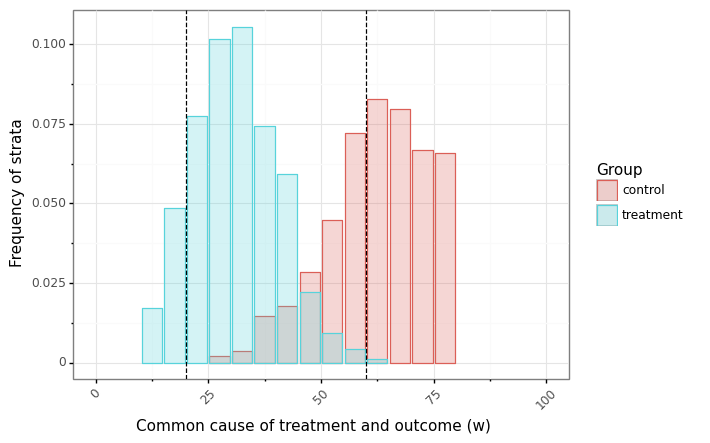

<ggplot: (-9223363280679442684)>

In [13]:
binned_dat2 = discretize_values(dat2)
plt_strat_2 = (ggplot(binned_dat2, aes(x="discrete_values", y="frac_freq", color="Group", fill="Group")) +
geom_bar(alpha=0.25, position="identity", stat="identity")+
 xlab("Common cause of treatment and outcome (w)")+
 ylab("Frequency of strata")+
 xlim(0,100) +
 geom_vline(xintercept=20, linetype="dashed") + geom_vline(xintercept=60, linetype="dashed")+
 theme_bw()+
 theme(axis_text_x = element_text(angle=45))
)

ggsave(plt_strat_2, filename="stratification_partial_overlap.pdf", width=3, height=3)
plt_strat_2

## Matching estimator

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: matching_perfect_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


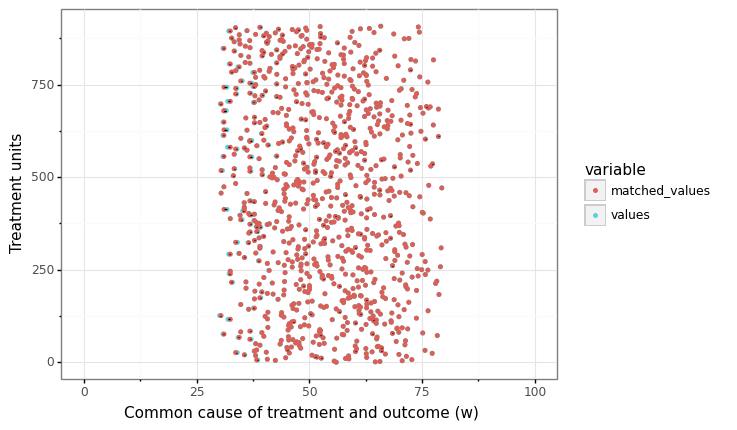

<ggplot: (8756172437035)>

In [14]:
treatment_dat0 = match_treatment_units(dat0)
plot_dat = pd.melt(treatment_dat0, id_vars="unit_id", value_vars=["values", "matched_values"])

plt_matching = (
    ggplot(plot_dat, aes(x="value", y="unit_id", color="variable", group="unit_id")) +
    geom_point(alpha=1, size=1)+
    geom_line(color="black") +
    xlim(0,100) +
    xlab("Common cause of treatment and outcome (w)") +
    ylab("Treatment units") +
    theme_bw()
)
ggsave(plt_matching, filename="matching_perfect_overlap.pdf", width=3, height=3)
plt_matching

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: matching_treatment_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


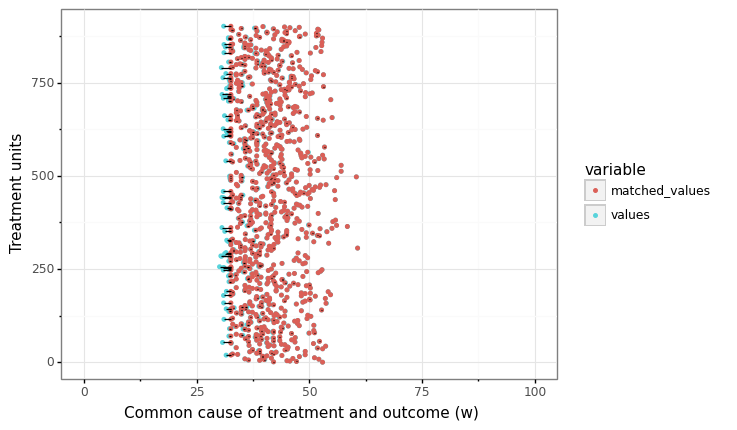

<ggplot: (8756170776689)>

In [15]:
treatment_dat1 = match_treatment_units(dat1)
plot_dat = pd.melt(treatment_dat1, id_vars="unit_id", value_vars=["values", "matched_values"])

plt_matching = (
    ggplot(plot_dat, aes(x="value", y="unit_id", color="variable", group="unit_id")) +
    geom_point(alpha=1, size=1)+
    geom_line(color="black") +
    xlim(0,100) +
    xlab("Common cause of treatment and outcome (w)") +
    ylab("Treatment units") +
    theme_bw()
)
ggsave(plt_matching, filename="matching_treatment_overlap.pdf", width=3, height=3)
plt_matching

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: matching_partial_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


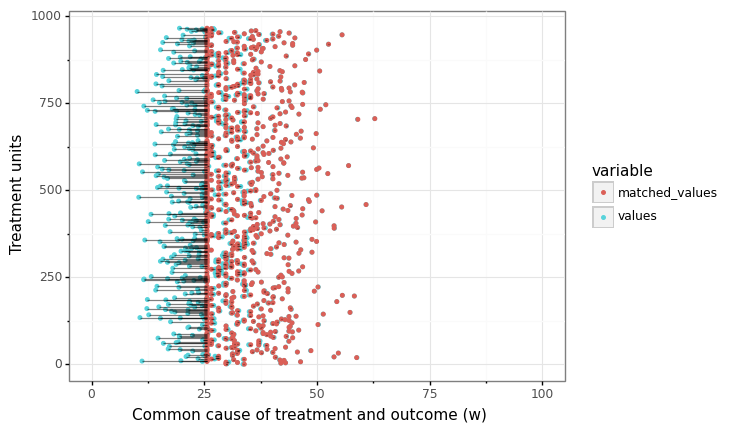

<ggplot: (8756171935229)>

In [16]:
treatment_dat2 = match_treatment_units(dat2)
plot_dat = pd.melt(treatment_dat2, id_vars="unit_id", value_vars=["values", "matched_values"])

plt_matching = (
    ggplot(plot_dat, aes(x="value", y="unit_id", color="variable", group="unit_id")) +
    geom_point(alpha=1, size=1)+
    geom_line(color="black", alpha=0.5) +
    xlim(0,100) +
    xlab("Common cause of treatment and outcome (w)") +
    ylab("Treatment units") +
    theme_bw()
)
ggsave(plt_matching, filename="matching_partial_overlap.pdf", width=3, height=3)
plt_matching

## Inverse propensity weighting estimator

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ipw_perfect_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


Accuracy: 0.637423653525819


/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


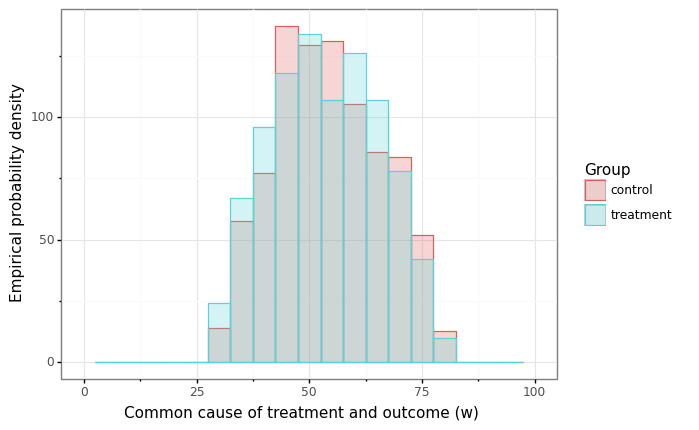

<ggplot: (-9223363280602033313)>


In [18]:
dat0 = add_inverse_propensity_weights(dat0)
plt_ipw_0 = (
 ggplot(dat0, aes(x="values", color="Group", fill="Group", weight="weight")) +
 geom_histogram(alpha=0.25, binwidth=5, position="identity")+
 xlab("Common cause of treatment and outcome (w)")+
 ylab("Empirical probability density")+
 theme_bw()+
 xlim(0,100)
)
ggsave(plt_ipw_0, filename="ipw_perfect_overlap.pdf", width=3, height=3)
print(plt_ipw_0)

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ipw_treatment_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


Accuracy: 0.8848314606741573


/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


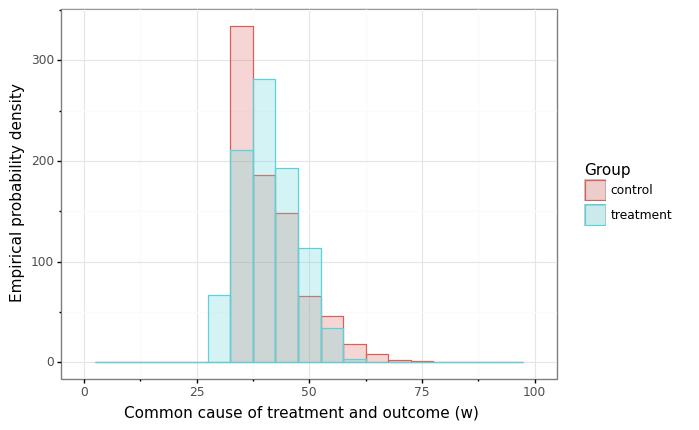

<ggplot: (-9223363280683795645)>


33.6781092287905

In [20]:
dat1 = add_inverse_propensity_weights(dat1)
plt_ipw_1 = (
 ggplot(dat1, aes(x="values", color="Group", fill="Group", weight="weight")) +
 geom_histogram(alpha=0.25, binwidth=5, position="identity")+
 xlab("Common cause of treatment and outcome (w)")+
 ylab("Empirical probability density")+
 theme_bw()+
 xlim(0,100)
)
ggsave(plt_ipw_1, filename="ipw_treatment_overlap.pdf", width=3, height=3)
print(plt_ipw_1)
max(dat1["weight"])

/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 3 x 3 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ipw_partial_overlap.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


Accuracy: 0.9267241379310345


/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/amit/python-virtual-envs/env3.6/lib/python3.6/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 4 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


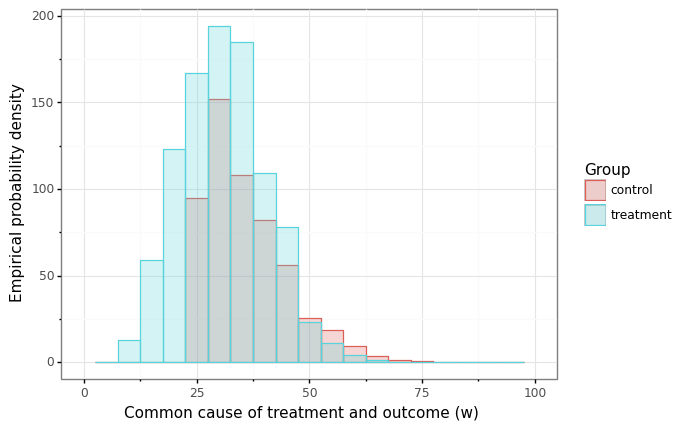

<ggplot: (-9223363280683563004)>


52.01846486304305

In [21]:
dat2 = add_inverse_propensity_weights(dat2)
plt_ipw_2 = (
 ggplot(dat2, aes(x="values", color="Group", fill="Group", weight="weight")) +
 geom_histogram(alpha=0.25, binwidth=5, position="identity")+
 xlab("Common cause of treatment and outcome (w)")+
 ylab("Empirical probability density")+
 theme_bw()+
 xlim(0,100)
)
ggsave(plt_ipw_2, filename="ipw_partial_overlap.pdf", width=3, height=3)
print(plt_ipw_2)
max(dat2["weight"])